In [1]:
from nba_api.stats.endpoints import boxscoretraditionalv2 as boxscore, leagueleaders as ll, leaguegamelog, boxscorefourfactorsv2 as ff, playerdashptreb as rebounds
from nba_api.stats.endpoints import playercareerstats as player_career, draftcombinestats as combine, leaguehustlestatsplayer as hustle, commonteamroster as roster
from nba_api.stats.endpoints import synergyplaytypes as synergy_types, playerprofilev2 as player_profile
from nba_api.stats.static import teams, players
import pandas as pd
from nba_api.stats.endpoints import commonplayerinfo, leaguedashplayershotlocations as shot_chart, leaguedashteamptshot as teamshot, leaguedashptdefend as defence
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, auc, plot_roc_curve, accuracy_score, recall_score, precision_score, silhouette_samples, silhouette_score
import requests
import warnings
import plotly.express as px
import plotly.graph_objects as go
import itertools
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.cluster import AgglomerativeClustering, KMeans, dbscan
from sklearn.mixture import GaussianMixture
import os


In [2]:
def get_player_hustle(start_szn, end_szn='2021-22', min_games = 0, min_mins = 0):
    hustle_stats = hustle.LeagueHustleStatsPlayer(per_mode_time='PerGame', season = start_szn, season_type_all_star='Regular Season')
    hustle_df = hustle_stats.get_data_frames()[0]
    hustle_df = hustle_df[(hustle_df['G']>min_games) & (hustle_df['DEFLECTIONS']>0)&(hustle_df['CONTESTED_SHOTS_3PT']>0) & (hustle_df['MIN']>min_mins)]
    start_year = int(start_szn[0:4])
    end_year = int('20'+end_szn[5:])
    

    current_szn = start_szn
    hustle_df['Season'] = [current_szn]*len(hustle_df)
    for i in range(start_year,end_year-1):
        current_szn =  str(int(current_szn[0:4]) +1) +'-'+ str(int(current_szn[5:])+1)
        print(current_szn)
        hustle_stats = hustle.LeagueHustleStatsPlayer(per_mode_time='PerGame', season = current_szn, season_type_all_star='Regular Season')
        temp = hustle_stats.get_data_frames()[0]
        temp = temp[(temp['G']>min_games)& (temp['DEFLECTIONS']>0)&(temp['CONTESTED_SHOTS_3PT']>0) & (temp['MIN']>min_mins)]
        temp['Season'] = [current_szn]*len(temp)
        hustle_df = pd.concat([hustle_df,temp], axis=0, ignore_index=True)
    return hustle_df


In [3]:
def get_defence(shot_type, start_szn, end_szn='2021-22', min_games = 0, min_mins = 0):
    
    defence_df = defence.LeagueDashPtDefend(defense_category=shot_type, league_id='00', season = start_szn, season_type_all_star='Regular Season', per_mode_simple='PerGame').get_data_frames()[0]
    start_year = int(start_szn[0:4])
    end_year = int('20'+end_szn[5:])
   
    current_szn = start_szn
    defence_df['Season'] = [current_szn]*len(defence_df)
    for i in range(start_year,end_year-1):
        current_szn =  str(int(current_szn[0:4]) +1) +'-'+ str(int(current_szn[5:])+1)
        temp = defence.LeagueDashPtDefend(defense_category= shot_type, league_id='00', season = current_szn, season_type_all_star='Regular Season', per_mode_simple='PerGame').get_data_frames()[0]
        temp['Season'] = [current_szn]*len(temp)
        defence_df = pd.concat([defence_df,temp], axis=0, ignore_index=True)
    return defence_df

## Synergy and Tracking

In [4]:
playtypes = np.array(('Cut',
	'Handoff',
	'Isolation',
	'Misc',
 	'OffScreen',
 	'Postup',
	'PRBallHandler',
 	'PRRollman',
 	'OffRebound',
 	'Spotup',
 	'Transition'))


In [5]:
def synergy_data(playtypes, grouping, szn_year):
    data = {}
    for i in playtypes:
       
        # Under the Header tab, select general and copy the first part of the request URL
        url = 'https://stats.nba.com/stats/synergyplaytypes?LeagueID=00&PerMode=PerGame&PlayType='+i+'&PlayerOrTeam=P&SeasonType=Regular Season&SeasonYear='+szn_year+'&TypeGrouping='+grouping
        #Header Tab, under "Query String Parameter" subsection
        
        # Header tab, under “Request Headers” subsection
        header = {
        'Accept': 'application/json, text/plain, */*',
        'Accept-Encoding': 'gzip, deflate, br',
        'Accept-Language': 'en-CA,en-GB;q=0.9,en-US;q=0.8,en;q=0.7',
        'Host': 'stats.nba.com',
        'Origin': 'https://www.nba.com',
        'Referer': 'https://www.nba.com/',

        'Sec-Fetch-Dest': 'empty',
        'Sec-Fetch-Mode': 'cors',
        'Sec-Fetch-Site': 'same-site',
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:103.0) Gecko/20100101 Firefox/103.0',
        'x-nba-stats-origin': 'stats',
        'x-nba-stats-token': 'true'}
        #Using Request library to get the data
        response = requests.get(url, headers=header)
        response_json = response.json()
        frame = pd.DataFrame(response_json['resultSets'][0]['rowSet'])
        frame.columns = response_json['resultSets'][0]['headers']
        frame['Season'] = szn_year
        data[i] = frame
        
    for i in data.keys():

        data[i].sort_values(by = 'POSS_PCT', ascending = False)
        data[i] = data[i].rename({'PERCENTILE': 'PPP PERCENTILE'}, axis='columns')
        data[i]['POSS PCT PERCENTILE'] = data[i]['POSS_PCT'].rank(pct = True)

    return data


In [6]:
def distance(szn_year):
    # Under the Header tab, select general and copy the first part of the request URL
    #Header Tab, under "Query String Parameter" subsection
    url = f'https://stats.nba.com/stats/leaguedashptstats?College=&Conference=&Country=&DateFrom=&DateTo=&Division=&DraftPick=&DraftYear=&GameScope=&Height=&LastNGames=0&LeagueID=00&Location=&Month=0&OpponentTeamID=0&Outcome=&PORound=0&PerMode=PerGame&PlayerExperience=&PlayerOrTeam=Player&PlayerPosition=&PtMeasureType=SpeedDistance&Season={szn_year}&SeasonSegment=&SeasonType=Regular Season&StarterBench=&TeamID=0&VsConference=&VsDivision=&Weight='   
    # Header tab, under “Request Headers” subsection
    header = {
    'Accept': 'application/json, text/plain, */*',
    'Accept-Encoding': 'gzip, deflate, br',
    'Accept-Language': 'en-CA,en-GB;q=0.9,en-US;q=0.8,en;q=0.7',
    'Host': 'stats.nba.com',
    'Origin': 'https://www.nba.com',
    'Referer': 'https://www.nba.com/',

    'Sec-Fetch-Dest': 'empty',
    'Sec-Fetch-Mode': 'cors',
    'Sec-Fetch-Site': 'same-site',
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:103.0) Gecko/20100101 Firefox/103.0',
    'x-nba-stats-origin': 'stats',
    'x-nba-stats-token': 'true'}
    #Using Request library to get the data
    response = requests.get(url, headers=header)
    response_json = response.json()
    frame = pd.DataFrame(response_json['resultSets'][0]['rowSet'])
    frame.columns = response_json['resultSets'][0]['headers']
    frame['Season'] = szn_year
    return frame

In [7]:
def shot_tracking(szn_year, category):
    
    url = 'https://stats.nba.com/stats/leaguedashptstats?College=&Conference=&Country=&DateFrom=&DateTo=&Division=&DraftPick=&DraftYear=&GameScope=&Height=&LastNGames=0&LeagueID=00&Location=&Month=0&OpponentTeamID=0&Outcome=&PORound=0&PerMode=PerGame&PlayerExperience=&PlayerOrTeam=Player&PlayerPosition=&PtMeasureType=Drives&Season=2021-22&SeasonSegment=&SeasonType=Regular Season&StarterBench=&TeamID=0&VsConference=&VsDivision=&Weight='
    
    url = url.replace('2021-22', szn_year)
    url= url.replace('Drives', category)
    # Under the Header tab, select general and copy the first part of the request URL
    
    # Header tab, under “Request Headers” subsection
    header = {
    'Accept': 'application/json, text/plain, */*',
    'Accept-Encoding': 'gzip, deflate, br',
    'Accept-Language': 'en-CA,en-GB;q=0.9,en-US;q=0.8,en;q=0.7',
    'Host': 'stats.nba.com',
    'Origin': 'https://www.nba.com',
    'Referer': 'https://www.nba.com/',

    'Sec-Fetch-Dest': 'empty',
    'Sec-Fetch-Mode': 'cors',
    'Sec-Fetch-Site': 'same-site',
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:103.0) Gecko/20100101 Firefox/103.0',
    'x-nba-stats-origin': 'stats',
    'x-nba-stats-token': 'true'}
    #Using Request library to get the data
    response = requests.get(url, headers=header)
    response_json = response.json()
    frame = pd.DataFrame(response_json['resultSets'][0]['rowSet'])
    frame.columns = response_json['resultSets'][0]['headers']
    frame['Season'] = szn_year
    
        
    

    return frame


In [517]:
hustle_df = get_player_hustle('2018-19')

2019-20
2020-21
2021-22


In [10]:
shot_areas = ( '3 Pointers', 'Less Than 6Ft','Less Than 10Ft')
def get_shot_areas(areas):

    dfs = {}
    for area in areas:
        area_df = get_defence(area, '2018-19')
       
        dfs[area] = area_df
        
        print(f'done {area}')
    return dfs

In [11]:
shot_dfs = get_shot_areas(shot_areas)

done 3 Pointers
done Less Than 6Ft
done Less Than 10Ft


In [13]:
shot_dfs['Less Than 6Ft'].iloc[1]

CLOSE_DEF_PERSON_ID                   203497
PLAYER_NAME                      Rudy Gobert
PLAYER_LAST_TEAM_ID               1610612762
PLAYER_LAST_TEAM_ABBREVIATION            UTA
PLAYER_POSITION                            C
AGE                                     27.0
GP                                        79
G                                         79
FREQ                                   0.412
FGM_LT_06                               4.54
FGA_LT_06                               8.67
LT_06_PCT                              0.524
NS_LT_06_PCT                           0.618
PLUSMINUS                             -0.094
Season                               2018-19
Name: 1, dtype: object

In [521]:

hustle_df['Activity Metric'] = hustle_df.DEFLECTIONS + hustle_df.CONTESTED_SHOTS_3PT + hustle_df.CONTESTED_SHOTS_2PT


In [522]:
for i in ('DEFLECTIONS', 'CONTESTED_SHOTS_3PT', "CONTESTED_SHOTS_2PT"):
    colname = i + ' '+'Percentile'
    hustle_df[colname] = hustle_df[i].rank(pct = True)

In [523]:
hustle_df.to_csv('Hustle_DF.csv', index = False)

In [524]:
for i in shot_dfs.keys():
    shot_dfs[i].to_csv('Defence'+i+'.csv', index = False)


In [30]:
hustle_df = pd.read_csv('hustle_df.csv')


In [16]:
shots_dfs = {}
for i in shot_areas:
    shots_dfs[i] = pd.read_csv('Defence'+i+'.csv')
    shots_dfs[i] = shots_dfs[i].iloc[:,[1,3,6,7,8,9,10,11,12,13,14]].copy()
    shots_dfs[i] = shots_dfs[i].rename({'FREQ': 'FREQ'+' '+i, 'PLUSMINUS': 'PLUSMINUS' + ' ' + i, 'PLAYER_LAST_TEAM_ABBREVIATION': 'TEAM_ABBREVIATION'}, axis='columns')
    




In [17]:
full_shot_df = pd.merge(shots_dfs['3 Pointers'], shots_dfs['Less Than 6Ft'], how='inner', on=['PLAYER_NAME', 'Season', 'TEAM_ABBREVIATION'])
full_shot_df = pd.merge(full_shot_df, shots_dfs['Less Than 10Ft'], how='inner', on = ['PLAYER_NAME', 'Season', 'TEAM_ABBREVIATION'])

In [18]:
full_shot_df.to_csv('full_shot.csv', index=False)

In [19]:
full_shot_df = pd.read_csv('full_shot.csv')

In [20]:
full_shot_df_final = full_shot_df[['PLAYER_NAME', 'TEAM_ABBREVIATION','Season', 'FREQ 3 Pointers', 'PLUSMINUS 3 Pointers', 'FREQ Less Than 6Ft','PLUSMINUS Less Than 6Ft',
'FREQ Less Than 10Ft', 'PLUSMINUS Less Than 10Ft']]

In [21]:
full_shot_df_final[full_shot_df_final['PLAYER_NAME']=='Nikola Jokic']

,PLAYER_NAME,TEAM_ABBREVIATION,Season,FREQ 3 Pointers,PLUSMINUS 3 Pointers,FREQ Less Than 6Ft,PLUSMINUS Less Than 6Ft,FREQ Less Than 10Ft,PLUSMINUS Less Than 10Ft
79,Nikola Jokic,DEN,2018-19,0.229,0.009,0.450,-0.059,0.549,-0.047
610,Nikola Jokic,DEN,2019-20,0.233,0.019,0.451,-0.033,0.556,-0.041
1145,Nikola Jokic,DEN,2020-21,0.222,-0.008,0.428,-0.016,0.527,-0.015
1626,Nikola Jokic,DEN,2021-22,0.216,0.011,0.394,-0.025,0.508,-0.029


In [22]:
drives = shot_tracking('2021-22', 'Drives')

pullup = shot_tracking('2021-22', 'PullUpShot')

passing = shot_tracking('2021-22', 'Passing')

catch_shoot = shot_tracking('2021-22', 'CatchShoot')

In [23]:
passing.columns

Index(['PLAYER_ID', 'PLAYER_NAME', 'TEAM_ID', 'TEAM_ABBREVIATION', 'GP', 'W',
       'L', 'MIN', 'PASSES_MADE', 'PASSES_RECEIVED', 'AST', 'FT_AST',
       'SECONDARY_AST', 'POTENTIAL_AST', 'AST_POINTS_CREATED', 'AST_ADJ',
       'AST_TO_PASS_PCT', 'AST_TO_PASS_PCT_ADJ', 'Season'],
      dtype='object')

In [522]:
passing = passing[['PLAYER_NAME', 'TEAM_ABBREVIATION','POTENTIAL_AST', 'Season']].copy()

In [523]:
pullup = pullup[['PLAYER_NAME', 'TEAM_ABBREVIATION','PULL_UP_FGA', 'PULL_UP_FG3_PCT', 'Season']].copy()

In [524]:
drives = drives[['PLAYER_NAME', 'TEAM_ABBREVIATION','DRIVES', 'DRIVE_PASSES_PCT','Season']].copy()

In [525]:
catch_shoot = catch_shoot[['PLAYER_NAME','TEAM_ABBREVIATION','CATCH_SHOOT_FG_PCT','CATCH_SHOOT_FGA','Season' ]].copy()

In [39]:
def basic_stats(szn_year, type='Base'):
    url = 'https://stats.nba.com/stats/leaguedashplayerstats?College=&Conference=&Country=&DateFrom=&DateTo=&Division=&DraftPick=&DraftYear=&GameScope=&GameSegment=&Height=&LastNGames=0&LeagueID=00&Location=&MeasureType=Base&Month=0&OpponentTeamID=0&Outcome=&PORound=0&PaceAdjust=N&PerMode=PerGame&Period=0&PlayerExperience=&PlayerPosition=&PlusMinus=N&Rank=N&Season=2021-22&SeasonSegment=&SeasonType=Regular Season&ShotClockRange=&StarterBench=&TeamID=0&TwoWay=0&VsConference=&VsDivision=&Weight='  
    url = url.replace('2021-22', szn_year)
    url = url.replace('Base', type)
    # Header tab, under “Request Headers” subsection
    header = {
    'Accept': 'application/json, text/plain, */*',
    'Accept-Encoding': 'gzip, deflate, br',
    'Accept-Language': 'en-CA,en-GB;q=0.9,en-US;q=0.8,en;q=0.7',
    'Host': 'stats.nba.com',
    'Origin': 'https://www.nba.com',
    'Referer': 'https://www.nba.com/',

    'Sec-Fetch-Dest': 'empty',
    'Sec-Fetch-Mode': 'cors',
    'Sec-Fetch-Site': 'same-site',
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:103.0) Gecko/20100101 Firefox/103.0',
    'x-nba-stats-origin': 'stats',
    'x-nba-stats-token': 'true'}
    #Using Request library to get the data
    response = requests.get(url, headers=header)
    response_json = response.json()
    frame = pd.DataFrame(response_json['resultSets'][0]['rowSet'])
    frame.columns = response_json['resultSets'][0]['headers']
    frame['Season'] = szn_year
    return frame

In [43]:
player_basic = basic_stats('2021-22')





In [42]:
player_advanced = basic_stats('2021-22', 'Advanced')

In [41]:
player_basic.columns

Index(['PLAYER_ID', 'PLAYER_NAME', 'NICKNAME', 'TEAM_ID', 'TEAM_ABBREVIATION',
       'AGE', 'GP', 'W', 'L', 'W_PCT', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M',
       'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST',
       'TOV', 'STL', 'BLK', 'BLKA', 'PF', 'PFD', 'PTS', 'PLUS_MINUS',
       'NBA_FANTASY_PTS', 'DD2', 'TD3', 'WNBA_FANTASY_PTS', 'GP_RANK',
       'W_RANK', 'L_RANK', 'W_PCT_RANK', 'MIN_RANK', 'FGM_RANK', 'FGA_RANK',
       'FG_PCT_RANK', 'FG3M_RANK', 'FG3A_RANK', 'FG3_PCT_RANK', 'FTM_RANK',
       'FTA_RANK', 'FT_PCT_RANK', 'OREB_RANK', 'DREB_RANK', 'REB_RANK',
       'AST_RANK', 'TOV_RANK', 'STL_RANK', 'BLK_RANK', 'BLKA_RANK', 'PF_RANK',
       'PFD_RANK', 'PTS_RANK', 'PLUS_MINUS_RANK', 'NBA_FANTASY_PTS_RANK',
       'DD2_RANK', 'TD3_RANK', 'WNBA_FANTASY_PTS_RANK', 'CFID', 'CFPARAMS',
       'Season'],
      dtype='object')

In [44]:
player_basic = player_basic[['PLAYER_NAME','TEAM_ABBREVIATION', 'FGA', 'FG3A']]

player_advanced = player_advanced[['PLAYER_NAME','TEAM_ABBREVIATION' ,'USG_PCT']]

In [24]:
shot_data = shot_chart.LeagueDashPlayerShotLocations(distance_range='By Zone', season_type_all_star='Regular Season',per_mode_detailed='PerGame' )
shot_df = shot_data.get_data_frames()[0]


In [25]:
shot_df

SHOT_CATEGORY                                                                 \
columns       PLAYER_ID      PLAYER_NAME     TEAM_ID TEAM_ABBREVIATION   AGE   
0                203932     Aaron Gordon  1610612743               DEN  26.0   
1               1630565      Aaron Henry  1610612755               PHI  22.0   
2               1628988    Aaron Holiday  1610612756               PHX  25.0   
3               1630174    Aaron Nesmith  1610612738               BOS  22.0   
4               1630598    Aaron Wiggins  1610612760               OKC  23.0   
..                  ...              ...         ...               ...   ...   
600              203897      Zach LaVine  1610612741               CHI  27.0   
601             1630285   Zavier Simpson  1610612760               OKC  25.0   
602             1630192       Zeke Nnaji  1610612743               DEN  21.0   
603             1630533  Ziaire Williams  1610612763               MEM  20.0   
604             1629597   Zylan Cheatham  1610612762               UTA  26.0   

SHOT_CATEGORY          Restricted Area             In The Paint (Non-RA)  ...  \
columns       NICKNAME             FGM  FGA FG_PCT                   FGM  ...   
0                Aaron             3.7  4.9  0.755                   0.4  ...   
1                Aaron             0.2  0.2  1.000                   0.0  ...   
2                Aaron             0.8  1.3  0.600                   0.8  ...   
3                Aaron             0.5  0.7  0.765                   0.1  ...   
4                Aaron             1.4  2.2  0.645                   0.8  ...   
..                 ...             ...  ...    ...                   ...  ...   
600               Zach             3.6  5.2  0.688                   0.6  ...   
601             Zavier             2.3  4.3  0.529                   2.3  ...   
602               Zeke             1.2  1.9  0.671                   0.1  ...   
603             Ziaire             1.1  1.4  0.833                   0.3  ...   
604              Zylan             0.0  1.0  0.000                   0.0  ...   

SHOT_CATEGORY Right Corner 3 Above the Break 3             Backcourt       \
columns               FG_PCT               FGM  FGA FG_PCT       FGM  FGA   
0                      0.356               0.7  1.9  0.340       0.0  0.1   
1                      0.000               0.0  0.2  0.000       NaN  NaN   
2                      0.500               0.5  1.4  0.372       0.0  0.0   
3                      0.211               0.4  1.4  0.310       0.0  0.0   
4                      0.261               0.5  1.7  0.298       0.0  0.0   
..                       ...               ...  ...    ...       ...  ...   
600                    0.583               2.2  6.0  0.366       0.0  0.0   
601                    0.000               0.3  2.0  0.125       0.0  0.0   
602                    0.529               0.5  1.1  0.435       0.0  0.0   
603                    0.447               0.6  1.9  0.297       0.0  0.0   
604                    0.000               0.0  1.0  0.000       NaN  NaN   

SHOT_CATEGORY        Corner 3              
columns       FG_PCT      FGM  FGA FG_PCT  
0                0.0      0.5  1.5  0.339  
1                NaN      0.0  0.0  0.000  
2                0.0      0.1  0.3  0.412  
3                0.0      0.2  0.9  0.205  
4                0.0      0.3  1.1  0.321  
..               ...      ...  ...    ...  
600              0.0      0.6  1.1  0.521  
601              0.0      0.0  0.0  0.000  
602              0.0      0.4  0.9  0.500  
603              0.0      0.7  2.0  0.342  
604              NaN      0.0  1.0  0.000  

[605 rows x 30 columns]

In [26]:
shot_df = shot_df[['','Restricted Area', 'In The Paint (Non-RA)', 'Mid-Range']]
player_names = shot_df[('', 'PLAYER_NAME')].values
team_abb = shot_df[('', 'TEAM_ABBREVIATION')].values
area_fga = {}

for area in ('Restricted Area', 'In The Paint (Non-RA)', 'Mid-Range'):
    
    area_fga[area + ' FGA'] = shot_df[(area, 'FGA')].values

In [27]:
twos_breakdown = pd.DataFrame(area_fga)
twos_breakdown['2PA'] = twos_breakdown.sum(axis=1)
twos_breakdown['PLAYER_NAME'] = player_names
twos_breakdown['TEAM_ABBREVIATION'] = team_abb


In [28]:
twos_breakdown[twos_breakdown['Mid-Range FGA']> twos_breakdown['2PA']]

,Restricted Area FGA,In The Paint (Non-RA) FGA,Mid-Range FGA,2PA,PLAYER_NAME,TEAM_ABBREVIATION


In [33]:
twos_breakdown[twos_breakdown['PLAYER_NAME']=='Derrick White']

,Restricted Area FGA,In The Paint (Non-RA) FGA,Mid-Range FGA,2PA,PLAYER_NAME,TEAM_ABBREVIATION
148,2.3,2.6,0.9,5.8,Derrick White,BOS


In [45]:
full_shot_pass = passing

for df in (drives, pullup, catch_shoot):
    full_shot_pass = pd.merge(full_shot_pass, df, how = 'inner', on = ['PLAYER_NAME', 'Season', 'TEAM_ABBREVIATION'])
full_shot_pass = pd.merge(full_shot_pass, twos_breakdown, on = ['PLAYER_NAME',  'TEAM_ABBREVIATION'] ,how='inner')
full_shot_pass = pd.merge(full_shot_pass, player_basic, how='inner', on = ['PLAYER_NAME',  'TEAM_ABBREVIATION'])
full_shot_pass = pd.merge(full_shot_pass, player_advanced, how='inner', on = ['PLAYER_NAME',  'TEAM_ABBREVIATION'])

C:\Users\rpand\AppData\Local\Temp\ipykernel_1504\3418698264.py:4: FutureWarning: Passing 'suffixes' which cause duplicate columns {'TEAM_ID_x', 'GP_x', 'MIN_x', 'PLAYER_ID_x', 'W_x', 'L_x'} in the result is deprecated and will raise a MergeError in a future version.
  full_shot_pass = pd.merge(full_shot_pass, df, how = 'inner', on = ['PLAYER_NAME', 'Season', 'TEAM_ABBREVIATION'])


In [765]:
full_shot_pass.to_csv('full_shot_pass.csv', index=False)

In [701]:
full_shot_pass.columns

Index(['PLAYER_NAME', 'POTENTIAL_AST', 'Season', 'DRIVES', 'DRIVE_PASSES_PCT',
       'PULL_UP_FGA', 'PULL_UP_FG3_PCT', 'CATCH_SHOOT_FG_PCT',
       'CATCH_SHOOT_FGA', 'Restricted Area FGA', 'In The Paint (Non-RA) FGA',
       'Mid-Range FGA', '2PA', 'FGA', 'USG_PCT'],
      dtype='object')

## Getting Historical Offensive Data

In [702]:
def historic_synergy(playtypes, grouping, start_year, end_year = '2021-22'):
    start_szn = int(start_year[0:4])
    end_year = int('20'+end_year[5:])
    historic_df = synergy_data(playtypes, grouping, start_year)
    current_szn = start_year
    
    for i in range(start_szn,end_year-1):
        current_szn =  str(int(current_szn[0:4]) +1) +'-'+ str(int(current_szn[5:])+1)
        print('starting'+' '+current_szn)
        temp_df = synergy_data(playtypes, grouping, current_szn)
        
        for j in historic_df.keys():
            print(f'Working on :{j}')
            historic_df[j] = pd.concat([historic_df[j],temp_df[j]], axis=0, ignore_index=True)
        print(f'Done {current_szn}')

    return(historic_df)

In [703]:
historic_offence = historic_synergy(playtypes, 'offensive', '2021-22')

In [704]:
for i in playtypes:
    historic_offence[i].to_csv('historic_offence'+'_'+i, index=False)

In [46]:
historic_offence_dfs = {}
for i in playtypes:
    historic_offence_dfs[i] = pd.read_csv('historic_offence'+'_'+i)

In [47]:
historic_offence_dfs['Handoff']

,SEASON_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,PLAY_TYPE,TYPE_GROUPING,PPP PERCENTILE,GP,...,PLUSONE_POSS_PCT,SCORE_POSS_PCT,EFG_PCT,POSS,PTS,FGM,FGA,FGMX,Season,POSS PCT PERCENTILE
0,22021,1629130,Duncan Robinson,1610612748,MIA,Miami Heat,Handoff,Offensive,0.779,79,...,0.005,0.364,0.535,2.3,2.4,0.8,2.2,1.4,2021-22,1.000000
1,22021,1630217,Desmond Bane,1610612763,MEM,Memphis Grizzlies,Handoff,Offensive,0.737,76,...,0.006,0.410,0.535,2.1,2.1,0.8,1.9,1.1,2021-22,0.937500
2,22021,201988,Patty Mills,1610612751,BKN,Brooklyn Nets,Handoff,Offensive,0.747,81,...,0.000,0.388,0.540,1.9,1.9,0.7,1.7,1.0,2021-22,0.980903
3,22021,1629673,Jordan Poole,1610612744,GSW,Golden State Warriors,Handoff,Offensive,0.554,76,...,0.006,0.365,0.489,2.2,2.0,0.7,1.8,1.1,2021-22,0.937500
4,22021,201939,Stephen Curry,1610612744,GSW,Golden State Warriors,Handoff,Offensive,0.571,64,...,0.013,0.354,0.460,2.5,2.3,0.7,2.0,1.3,2021-22,0.866319
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,22021,1630182,Josh Green,1610612742,DAL,Dallas Mavericks,Handoff,Offensive,0.014,67,...,0.000,0.100,0.143,0.1,0.0,0.0,0.1,0.1,2021-22,0.154514
284,22021,1629164,Brandon Goodwin,1610612739,CLE,Cleveland Cavaliers,Handoff,Offensive,0.007,36,...,0.000,0.091,0.100,0.3,0.1,0.0,0.3,0.3,2021-22,0.411458
285,22021,1628365,Markelle Fultz,1610612753,ORL,Orlando Magic,Handoff,Offensive,0.007,18,...,0.000,0.091,0.111,0.6,0.1,0.1,0.5,0.4,2021-22,0.347222
286,22021,1628367,Josh Jackson,1610612765,DET,Detroit Pistons,Handoff,Offensive,0.003,39,...,0.000,0.083,0.100,0.3,0.1,0.0,0.3,0.2,2021-22,0.220486


In [767]:
for i in historic_offence_dfs.keys():
    historic_offence_dfs[i]= historic_offence_dfs[i].rename({'PPP': i + ' PPP', 'POSS': i + ' POSS', 'POSS_PCT': i+' FREQ'}, axis='columns')
    historic_offence_dfs[i] = historic_offence_dfs[i][['PLAYER_NAME', 'Season', 'TEAM_ABBREVIATION',i + ' PPP',  i + ' FREQ',i + ' POSS','GP']]

In [768]:
historic_offence_dfs.keys()

dict_keys(['Cut', 'Handoff', 'Isolation', 'Misc', 'OffScreen', 'Postup', 'PRBallHandler', 'PRRollman', 'OffRebound', 'Spotup', 'Transition'])

In [769]:
all_offence = pd.merge(historic_offence_dfs['Cut'], historic_offence_dfs['Handoff'], how = 'outer', on=['PLAYER_NAME', 'Season','GP', 'TEAM_ABBREVIATION'])

for i in range(2, len(historic_offence_dfs.keys())):
    key = list(historic_offence_dfs.keys())[i]
    all_offence = pd.merge(all_offence, historic_offence_dfs[key], how = 'outer', on=['PLAYER_NAME', 'Season', 'GP', 'TEAM_ABBREVIATION'])

In [770]:
all_offence = all_offence.drop_duplicates(['PLAYER_NAME', 'Season', 'GP', 'TEAM_ABBREVIATION'])

In [771]:
poss_cols = [i + ' POSS' for i in historic_offence.keys()]

In [772]:
all_offence['Total Poss'] = all_offence[poss_cols].sum(axis=1)

In [773]:
all_offence = all_offence.drop(poss_cols, axis='columns')

In [774]:

all_offence = pd.merge(all_offence, hustle_df[['PLAYER_NAME',  "MIN", "Season"]], on = ['PLAYER_NAME', 'Season'], how='inner')

In [775]:
shot_pass =pd.read_csv('full_shot_pass.csv')

In [776]:
all_offence = pd.merge(all_offence, shot_pass, on = ['PLAYER_NAME', 'Season'], how='inner')

In [777]:
all_offence = all_offence.fillna(0)

In [778]:
all_offence = all_offence.drop_duplicates(['PLAYER_NAME', 'Season'])

In [779]:
all_offence.columns

Index(['PLAYER_NAME', 'Season', 'Cut PPP', 'Cut FREQ', 'GP', 'Handoff PPP',
       'Handoff FREQ', 'Isolation PPP', 'Isolation FREQ', 'Misc PPP',
       'Misc FREQ', 'OffScreen PPP', 'OffScreen FREQ', 'Postup PPP',
       'Postup FREQ', 'PRBallHandler PPP', 'PRBallHandler FREQ',
       'PRRollman PPP', 'PRRollman FREQ', 'OffRebound PPP', 'OffRebound FREQ',
       'Spotup PPP', 'Spotup FREQ', 'Transition PPP', 'Transition FREQ',
       'Total Poss', 'MIN', 'POTENTIAL_AST', 'DRIVES', 'DRIVE_PASSES_PCT',
       'PULL_UP_FGA', 'PULL_UP_FG3_PCT', 'CATCH_SHOOT_FG_PCT',
       'CATCH_SHOOT_FGA', 'Restricted Area FGA', 'In The Paint (Non-RA) FGA',
       'Mid-Range FGA', '2PA', 'FGA', 'FG3A', 'USG_PCT'],
      dtype='object')

In [780]:
all_offence['POTENTIAL_AST FREQ'] = all_offence['POTENTIAL_AST']/all_offence['Total Poss']

for area in ('Restricted Area', 'In The Paint (Non-RA)', 'Mid-Range'):
    all_offence[area + ' FREQ'] = all_offence[area+ ' FGA']/all_offence['2PA']
    all_offence = all_offence.drop(area+' FGA', axis=1)

In [781]:
all_offence['3P FREQ'] = all_offence['FG3A']/all_offence['FGA']

In [782]:
all_offence['Drives FREQ'] = all_offence['DRIVES']/all_offence['Total Poss']

for area in ('PULL_UP', 'CATCH_SHOOT'):
    all_offence[area + ' FREQ'] = all_offence[area+ '_FGA']/all_offence['FGA']
    all_offence = all_offence.drop(area+'_FGA', axis=1)

In [783]:
all_offence = all_offence.drop(['DRIVES', '2PA', 'FGA' ], axis=1)

In [784]:
all_offence['Mid-Range FREQ'].value_counts()

0.000000    26
0.090909     8
0.250000     8
0.125000     7
0.333333     6
            ..
0.021277     1
0.074534     1
0.092593     1
0.060000     1
0.465116     1
Name: Mid-Range FREQ, Length: 318, dtype: int64

In [785]:
all_offence.to_csv('all_offence.csv', index=False)

TypeError: ufunc 'isinf' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

## Getting the Historical Defensive Data

In [532]:
def historic_drebs(start_year ,end_year='2021-22'):
    start_szn =  int(start_year[0:4])
    end_year = int('20'+end_year[5:])
    reb_df = dreb_tracking(start_year)
    current_szn = start_year
    for i in range(start_szn,end_year-1):
        current_szn =  str(int(current_szn[0:4]) +1) +'-'+ str(int(current_szn[5:])+1)
        print('starting'+' '+current_szn)
        temp_df = dreb_tracking(current_szn)
        reb_df = pd.concat([reb_df, temp_df], axis=0, ignore_index=True)
    return reb_df


In [533]:
def historic_dist(start_year, end_year='2021-22'):
    start_szn =  int(start_year[0:4])
    end_year = int('20'+end_year[5:])
    dist_df = distance(start_year)
    current_szn = start_year
    for i in range(start_szn,end_year-1):
        current_szn =  str(int(current_szn[0:4]) +1) +'-'+ str(int(current_szn[5:])+1)
        print('starting'+' '+current_szn)
        temp_df = distance(current_szn)
        dist_df = pd.concat([dist_df, temp_df], axis=0, ignore_index=True)
    return dist_df


In [534]:
reb_df = historic_drebs('2018-19')

starting 2019-20
starting 2020-21
starting 2021-22


In [535]:
reb_df['Season'].value_counts()

2021-22    605
2020-21    540
2018-19    530
2019-20    529
Name: Season, dtype: int64

In [536]:
dist_df = historic_dist('2018-19')

starting 2019-20
starting 2020-21
starting 2021-22


In [537]:
dist_df['Season'].value_counts()

2021-22    605
2020-21    540
2018-19    530
2019-20    529
Name: Season, dtype: int64

In [538]:
dist_df= dist_df[['PLAYER_NAME', 'Season','DIST_MILES_DEF', 'AVG_SPEED_DEF']]
dist_df.to_csv('dist_df.csv', index=False)

In [539]:
reb_df = reb_df[['PLAYER_NAME', 'Season', 'REB_CONTEST_PCT', 'AVG_REB_DIST']]
reb_df.to_csv('reb_df.csv', index=False)

In [12]:
historic_defence = historic_synergy(playtypes[[1,2,4,5,6,7,9]], 'defensive', '2018-19')

starting 2019-20
Working on :Handoff
Working on :Isolation
Working on :OffScreen
Working on :Postup
Working on :PRBallHandler
Working on :PRRollman
Working on :Spotup
Done 2019-20
starting 2020-21
Working on :Handoff
Working on :Isolation
Working on :OffScreen
Working on :Postup
Working on :PRBallHandler
Working on :PRRollman
Working on :Spotup
Done 2020-21
starting 2021-22
Working on :Handoff
Working on :Isolation
Working on :OffScreen
Working on :Postup
Working on :PRBallHandler
Working on :PRRollman
Working on :Spotup
Done 2021-22


In [13]:
for i in playtypes[[1,2,4,5,6,7,9]]:
    historic_defence[i].to_csv('historic_defence'+'_'+i, index=False)

### Merge the historical data into one large df

In [111]:
historic_defence_dfs = {}
for i in playtypes[[1,2,4,5,6,7,9]]:
    historic_defence_dfs[i] = pd.read_csv('historic_defence'+'_'+i)

In [112]:
full_shot_df = pd.read_csv('full_shot.csv')

In [113]:
rebs_df = pd.read_csv('reb_df.csv')

In [114]:
dist_df = pd.read_csv('dist_df.csv')

In [115]:
historic_defence_dfs['Handoff'][historic_defence_dfs['Handoff']['SEASON_ID']=='22021'].columns

Index(['SEASON_ID', 'PLAYER_ID', 'PLAYER_NAME', 'TEAM_ID', 'TEAM_ABBREVIATION',
       'TEAM_NAME', 'PLAY_TYPE', 'TYPE_GROUPING', 'PPP PERCENTILE', 'GP',
       'POSS_PCT', 'PPP', 'FG_PCT', 'FT_POSS_PCT', 'TOV_POSS_PCT',
       'SF_POSS_PCT', 'PLUSONE_POSS_PCT', 'SCORE_POSS_PCT', 'EFG_PCT', 'POSS',
       'PTS', 'FGM', 'FGA', 'FGMX', 'Season', 'POSS PCT PERCENTILE'],
      dtype='object')

In [116]:
for i in historic_defence_dfs.keys():
    historic_defence_dfs[i]= historic_defence_dfs[i].rename({'PPP':'DEF ' + i + ' PPP', 'POSS':'DEF ' +  i + ' POSS', 'POSS_PCT':'DEF ' +  i+' FREQ'}, axis='columns')
    historic_defence_dfs[i] = historic_defence_dfs[i][['PLAYER_NAME', 'Season','DEF ' +  i + ' PPP',  'DEF ' + i + ' FREQ','GP']]

In [117]:
historic_defence_dfs['Handoff'][historic_defence_dfs['Handoff']['PLAYER_NAME']=='Aaron Gordon']

,PLAYER_NAME,Season,DEF Handoff PPP,DEF Handoff FREQ,GP
288,Aaron Gordon,2018-19,0.836,0.081,78
529,Aaron Gordon,2019-20,0.809,0.069,62
678,Aaron Gordon,2020-21,0.563,0.069,25
818,Aaron Gordon,2020-21,1.077,0.096,25
1302,Aaron Gordon,2021-22,1.000,0.077,75


In [118]:
all_defence = pd.merge(historic_defence_dfs['Handoff'], historic_defence_dfs['Isolation'], how = 'outer', on=['PLAYER_NAME', 'Season','GP'])

for i in range(2, len(historic_defence_dfs.keys())):
    key = list(historic_defence_dfs.keys())[i]
    all_defence = pd.merge(all_defence, historic_defence_dfs[key], how = 'outer', on=['PLAYER_NAME', 'Season', 'GP'])

In [119]:
all_defence.min(axis=0)

PLAYER_NAME               Aaron Gordon
Season                         2018-19
DEF Handoff PPP                  0.167
DEF Handoff FREQ                 0.007
GP                                   2
DEF Isolation PPP                 0.19
DEF Isolation FREQ                0.02
DEF OffScreen PPP                  0.0
DEF OffScreen FREQ               0.007
DEF Postup PPP                   0.182
DEF Postup FREQ                  0.014
DEF PRBallHandler PPP              0.0
DEF PRBallHandler FREQ           0.008
DEF PRRollman PPP                  0.0
DEF PRRollman FREQ               0.013
DEF Spotup PPP                     0.0
DEF Spotup FREQ                  0.093
dtype: object

In [120]:
all_defence[ (all_defence['PLAYER_NAME']=='Serge Ibaka')]

,PLAYER_NAME,Season,DEF Handoff PPP,DEF Handoff FREQ,GP,DEF Isolation PPP,DEF Isolation FREQ,DEF OffScreen PPP,DEF OffScreen FREQ,DEF Postup PPP,DEF Postup FREQ,DEF PRBallHandler PPP,DEF PRBallHandler FREQ,DEF PRRollman PPP,DEF PRRollman FREQ,DEF Spotup PPP,DEF Spotup FREQ
1471,Serge Ibaka,2018-19,NaN,NaN,74,1.074,0.065,1.1,0.01,0.919,0.071,1.182,0.01,1.182,0.053,0.756,0.157
1551,Serge Ibaka,2019-20,NaN,NaN,55,0.745,0.086,NaN,NaN,0.640,0.039,NaN,NaN,1.030,0.051,0.902,0.254
1645,Serge Ibaka,2020-21,NaN,NaN,41,0.783,0.083,NaN,NaN,0.913,0.041,NaN,NaN,1.056,0.065,0.883,0.138
1723,Serge Ibaka,2021-22,NaN,NaN,19,1.200,0.089,NaN,NaN,NaN,NaN,NaN,NaN,1.000,0.080,1.500,0.107
1734,Serge Ibaka,2021-22,NaN,NaN,35,1.071,0.105,NaN,NaN,0.556,0.067,NaN,NaN,1.400,0.056,0.830,0.199


In [121]:
all_defence =pd.merge(all_defence, full_shot_df_final, how='inner', on = ['PLAYER_NAME', 'Season'])
all_defence[all_defence['PLAYER_NAME']=='Nikola Jokic']

,PLAYER_NAME,Season,DEF Handoff PPP,DEF Handoff FREQ,GP,DEF Isolation PPP,DEF Isolation FREQ,DEF OffScreen PPP,DEF OffScreen FREQ,DEF Postup PPP,...,DEF PRRollman PPP,DEF PRRollman FREQ,DEF Spotup PPP,DEF Spotup FREQ,FREQ 3 Pointers,PLUSMINUS 3 Pointers,FREQ Less Than 6Ft,PLUSMINUS Less Than 6Ft,FREQ Less Than 10Ft,PLUSMINUS Less Than 10Ft
419,Nikola Jokic,2019-20,1.167,0.011,73,0.659,0.082,NaN,NaN,0.714,...,1.128,0.073,0.922,0.169,0.233,0.019,0.451,-0.033,0.556,-0.041
683,Nikola Jokic,2020-21,0.600,0.009,72,0.625,0.060,0.667,0.011,0.800,...,0.877,0.061,1.318,0.165,0.222,-0.008,0.428,-0.016,0.527,-0.015
1534,Nikola Jokic,2018-19,NaN,NaN,80,0.800,0.076,0.667,0.011,0.862,...,0.966,0.082,0.896,0.183,0.229,0.009,0.450,-0.059,0.549,-0.047
1833,Nikola Jokic,2021-22,NaN,NaN,74,0.961,0.063,NaN,NaN,1.019,...,0.958,0.078,1.019,0.173,0.216,0.011,0.394,-0.025,0.508,-0.029


In [122]:
all_defence = pd.merge(all_defence, hustle_df[['PLAYER_NAME', 'Season', 'MIN', 'DEFLECTIONS','PCT_LOOSE_BALLS_RECOVERED_DEF']], on = ['PLAYER_NAME', 'Season'], how = 'inner')
all_defence[all_defence['PLAYER_NAME']=='Nikola Jokic']

,PLAYER_NAME,Season,DEF Handoff PPP,DEF Handoff FREQ,GP,DEF Isolation PPP,DEF Isolation FREQ,DEF OffScreen PPP,DEF OffScreen FREQ,DEF Postup PPP,...,DEF Spotup FREQ,FREQ 3 Pointers,PLUSMINUS 3 Pointers,FREQ Less Than 6Ft,PLUSMINUS Less Than 6Ft,FREQ Less Than 10Ft,PLUSMINUS Less Than 10Ft,MIN,DEFLECTIONS,PCT_LOOSE_BALLS_RECOVERED_DEF
419,Nikola Jokic,2019-20,1.167,0.011,73,0.659,0.082,NaN,NaN,0.714,...,0.169,0.233,0.019,0.451,-0.033,0.556,-0.041,32.0,2.79,0.507
683,Nikola Jokic,2020-21,0.600,0.009,72,0.625,0.060,0.667,0.011,0.800,...,0.165,0.222,-0.008,0.428,-0.016,0.527,-0.015,34.6,2.76,0.345
1534,Nikola Jokic,2018-19,NaN,NaN,80,0.800,0.076,0.667,0.011,0.862,...,0.183,0.229,0.009,0.450,-0.059,0.549,-0.047,31.3,2.44,0.488
1833,Nikola Jokic,2021-22,NaN,NaN,74,0.961,0.063,NaN,NaN,1.019,...,0.173,0.216,0.011,0.394,-0.025,0.508,-0.029,33.5,2.85,0.413


In [123]:
defence_2021 = all_defence[all_defence['Season']=='2021-22'].fillna(0)

In [125]:
all_defence = all_defence.fillna(0)

In [126]:
dist_df

,PLAYER_NAME,Season,DIST_MILES_DEF,AVG_SPEED_DEF
0,Aaron Gordon,2018-19,1.12,3.79
1,Aaron Holiday,2018-19,0.49,4.12
2,Abdel Nader,2018-19,0.45,4.27
3,Al Horford,2018-19,0.96,3.64
4,Al-Farouq Aminu,2018-19,0.96,3.93
...,...,...,...,...
2199,Zach LaVine,2021-22,1.17,3.82
2200,Zavier Simpson,2021-22,1.39,3.77
2201,Zeke Nnaji,2021-22,0.61,4.07
2202,Ziaire Williams,2021-22,0.75,4.01


In [127]:

all_defence = pd.merge(all_defence, rebs_df, on = ['PLAYER_NAME', 'Season'], how='inner')
all_defence = pd.merge(all_defence, dist_df, on = ['PLAYER_NAME', 'Season'], how='inner')

In [128]:
all_defence

,PLAYER_NAME,Season,DEF Handoff PPP,DEF Handoff FREQ,GP,DEF Isolation PPP,DEF Isolation FREQ,DEF OffScreen PPP,DEF OffScreen FREQ,DEF Postup PPP,...,PLUSMINUS Less Than 6Ft,FREQ Less Than 10Ft,PLUSMINUS Less Than 10Ft,MIN,DEFLECTIONS,PCT_LOOSE_BALLS_RECOVERED_DEF,REB_CONTEST_PCT,AVG_REB_DIST,DIST_MILES_DEF,AVG_SPEED_DEF
0,Alex Caruso,2018-19,0.167,0.052,26,0.793,0.126,1.000,0.082,1.056,...,0.021,0.404,0.041,21.2,1.88,0.211,0.269,10.2,0.76,3.89
1,Al Horford,2018-19,0.500,0.011,68,0.765,0.106,0.909,0.012,0.981,...,-0.059,0.533,-0.042,29.0,1.38,0.684,0.384,6.4,0.96,3.64
2,Semi Ojeleye,2018-19,0.455,0.054,56,0.900,0.147,1.538,0.064,0.933,...,0.001,0.449,0.013,10.6,0.21,0.529,0.395,8.3,0.38,3.90
3,Thabo Sefolosha,2018-19,0.455,0.056,50,0.684,0.097,0.583,0.062,1.318,...,-0.029,0.595,-0.042,12.2,1.26,0.714,0.205,6.2,0.42,3.90
4,Iman Shumpert,2018-19,0.455,0.089,20,1.071,0.113,1.417,0.097,0.000,...,0.105,0.472,0.106,23.9,1.87,0.557,0.202,8.1,0.87,3.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2027,Louis King,2021-22,0.000,0.000,10,0.000,0.000,0.000,0.000,0.000,...,-0.082,0.540,-0.093,10.4,0.90,1.000,0.333,8.4,0.39,4.05
2028,Jaylen Hoard,2021-22,0.000,0.000,7,0.000,0.000,0.000,0.000,0.000,...,-0.017,0.461,0.001,34.2,1.71,0.333,0.333,4.5,1.20,4.15
2029,Willie Cauley-Stein,2021-22,0.000,0.000,11,0.000,0.000,0.000,0.000,0.000,...,0.034,0.500,0.078,9.1,0.60,0.333,0.500,4.7,0.32,4.08
2030,Moses Brown,2021-22,0.000,0.000,14,0.000,0.000,0.000,0.000,0.000,...,-0.087,0.525,-0.065,8.6,0.28,0.375,0.467,4.2,0.30,4.07


In [129]:
all_defence = all_defence.drop_duplicates(['PLAYER_NAME','GP', 'Season'])

In [130]:
all_defence

,PLAYER_NAME,Season,DEF Handoff PPP,DEF Handoff FREQ,GP,DEF Isolation PPP,DEF Isolation FREQ,DEF OffScreen PPP,DEF OffScreen FREQ,DEF Postup PPP,...,PLUSMINUS Less Than 6Ft,FREQ Less Than 10Ft,PLUSMINUS Less Than 10Ft,MIN,DEFLECTIONS,PCT_LOOSE_BALLS_RECOVERED_DEF,REB_CONTEST_PCT,AVG_REB_DIST,DIST_MILES_DEF,AVG_SPEED_DEF
0,Alex Caruso,2018-19,0.167,0.052,26,0.793,0.126,1.000,0.082,1.056,...,0.021,0.404,0.041,21.2,1.88,0.211,0.269,10.2,0.76,3.89
1,Al Horford,2018-19,0.500,0.011,68,0.765,0.106,0.909,0.012,0.981,...,-0.059,0.533,-0.042,29.0,1.38,0.684,0.384,6.4,0.96,3.64
2,Semi Ojeleye,2018-19,0.455,0.054,56,0.900,0.147,1.538,0.064,0.933,...,0.001,0.449,0.013,10.6,0.21,0.529,0.395,8.3,0.38,3.90
3,Thabo Sefolosha,2018-19,0.455,0.056,50,0.684,0.097,0.583,0.062,1.318,...,-0.029,0.595,-0.042,12.2,1.26,0.714,0.205,6.2,0.42,3.90
4,Iman Shumpert,2018-19,0.455,0.089,20,1.071,0.113,1.417,0.097,0.000,...,0.105,0.472,0.106,23.9,1.87,0.557,0.202,8.1,0.87,3.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2027,Louis King,2021-22,0.000,0.000,10,0.000,0.000,0.000,0.000,0.000,...,-0.082,0.540,-0.093,10.4,0.90,1.000,0.333,8.4,0.39,4.05
2028,Jaylen Hoard,2021-22,0.000,0.000,7,0.000,0.000,0.000,0.000,0.000,...,-0.017,0.461,0.001,34.2,1.71,0.333,0.333,4.5,1.20,4.15
2029,Willie Cauley-Stein,2021-22,0.000,0.000,11,0.000,0.000,0.000,0.000,0.000,...,0.034,0.500,0.078,9.1,0.60,0.333,0.500,4.7,0.32,4.08
2030,Moses Brown,2021-22,0.000,0.000,14,0.000,0.000,0.000,0.000,0.000,...,-0.087,0.525,-0.065,8.6,0.28,0.375,0.467,4.2,0.30,4.07


In [131]:
all_defence.isna().sum()

PLAYER_NAME                      0
Season                           0
DEF Handoff PPP                  0
DEF Handoff FREQ                 0
GP                               0
DEF Isolation PPP                0
DEF Isolation FREQ               0
DEF OffScreen PPP                0
DEF OffScreen FREQ               0
DEF Postup PPP                   0
DEF Postup FREQ                  0
DEF PRBallHandler PPP            0
DEF PRBallHandler FREQ           0
DEF PRRollman PPP                0
DEF PRRollman FREQ               0
DEF Spotup PPP                   0
DEF Spotup FREQ                  0
FREQ 3 Pointers                  0
PLUSMINUS 3 Pointers             0
FREQ Less Than 6Ft               0
PLUSMINUS Less Than 6Ft          0
FREQ Less Than 10Ft              0
PLUSMINUS Less Than 10Ft         0
MIN                              0
DEFLECTIONS                      0
PCT_LOOSE_BALLS_RECOVERED_DEF    0
REB_CONTEST_PCT                  0
AVG_REB_DIST                     0
DIST_MILES_DEF      

In [282]:
all_defence['DEFLECTIONS Per36'] = (all_defence['DEFLECTIONS']/all_defence['MIN'])*36

C:\Users\rpand\AppData\Local\Temp\ipykernel_38572\254949371.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [283]:

all_defence.to_csv('all_defence.csv', index=False)

In [284]:
all_defence.columns

Index(['PLAYER_NAME', 'Season', 'DEF Handoff PPP', 'DEF Handoff FREQ', 'GP',
       'DEF Isolation PPP', 'DEF Isolation FREQ', 'DEF OffScreen PPP',
       'DEF OffScreen FREQ', 'DEF Postup PPP', 'DEF Postup FREQ',
       'DEF PRBallHandler PPP', 'DEF PRBallHandler FREQ', 'DEF PRRollman PPP',
       'DEF PRRollman FREQ', 'DEF Spotup PPP', 'DEF Spotup FREQ',
       'FREQ 3 Pointers', 'PLUSMINUS 3 Pointers', 'FREQ Less Than 6Ft',
       'PLUSMINUS Less Than 6Ft', 'FREQ Less Than 10Ft',
       'PLUSMINUS Less Than 10Ft', 'MIN', 'DEFLECTIONS',
       'PCT_LOOSE_BALLS_RECOVERED_DEF', 'REB_CONTEST_PCT', 'AVG_REB_DIST',
       'DIST_MILES_DEF', 'AVG_SPEED_DEF', 'DEFLECTIONS Per36'],
      dtype='object')

## Clustering

In [13]:
all_defence_clust = pd.read_csv('all_defence.csv')




all_defence_clust = all_defence_clust[(all_defence_clust['GP']>20)& (all_defence_clust['MIN']>15)&(all_defence_clust['Season']=='2021-22')]




In [14]:
all_defence_clust[all_defence_clust['PLAYER_NAME'] =='Pascal Siakam']

,PLAYER_NAME,Season,DEF Handoff PPP,DEF Handoff FREQ,GP,DEF Isolation PPP,DEF Isolation FREQ,DEF OffScreen PPP,DEF OffScreen FREQ,DEF Postup PPP,...,FREQ Less Than 10Ft,PLUSMINUS Less Than 10Ft,MIN,DEFLECTIONS,PCT_LOOSE_BALLS_RECOVERED_DEF,REB_CONTEST_PCT,AVG_REB_DIST,DIST_MILES_DEF,AVG_SPEED_DEF,DEFLECTIONS Per36
1277,Pascal Siakam,2021-22,1.083,0.04,69,0.645,0.085,1.435,0.052,0.871,...,0.479,-0.03,37.9,2.0,0.487,0.331,6.0,1.22,3.67,1.899736


In [286]:
def_train = all_defence_clust.drop(['PLAYER_NAME', 'Season', 'MIN', 'GP', 'DEFLECTIONS'], axis='columns')

In [287]:
def_train.columns

Index(['DEF Handoff PPP', 'DEF Handoff FREQ', 'DEF Isolation PPP',
       'DEF Isolation FREQ', 'DEF OffScreen PPP', 'DEF OffScreen FREQ',
       'DEF Postup PPP', 'DEF Postup FREQ', 'DEF PRBallHandler PPP',
       'DEF PRBallHandler FREQ', 'DEF PRRollman PPP', 'DEF PRRollman FREQ',
       'DEF Spotup PPP', 'DEF Spotup FREQ', 'FREQ 3 Pointers',
       'PLUSMINUS 3 Pointers', 'FREQ Less Than 6Ft', 'PLUSMINUS Less Than 6Ft',
       'FREQ Less Than 10Ft', 'PLUSMINUS Less Than 10Ft',
       'PCT_LOOSE_BALLS_RECOVERED_DEF', 'REB_CONTEST_PCT', 'AVG_REB_DIST',
       'DIST_MILES_DEF', 'AVG_SPEED_DEF', 'DEFLECTIONS Per36'],
      dtype='object')

In [288]:
norm_train = pd.DataFrame(StandardScaler().fit_transform(def_train),columns = def_train.columns)

## Try K-Means

c:\Users\rpand\anaconda3\envs\nba_app_env\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.

c:\Users\rpand\anaconda3\envs\nba_app_env\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.

c:\Users\rpand\anaconda3\envs\nba_app_env\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.

c:\Users\rpand\anaconda3\envs\nba_app_env\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning:

KMeans is known to have

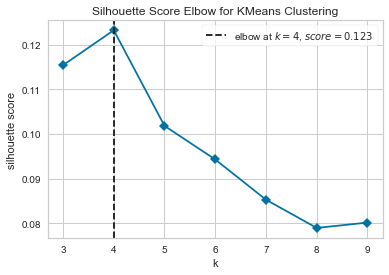

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [289]:
kmean = KMeans(random_state=1)
visualizer = KElbowVisualizer(kmean, 
                              k=(3,10),   
                              locate_elbow=True, # Locate the elbow? Default is true.
                              timings=False, # Plot the timings to train?
                              metric = 'silhouette'
                             )   

visualizer.fit(norm_train)        
visualizer.show()   

## Try GMM

In [290]:
def gauss_tune(data,min_clust, max_clust, seed=29):
    
    cluster_amounts = np.arange(min_clust, max_clust+1)
    bics = []
    clust_num = np.arange(1,len(cluster_amounts)-1)
    
    for i in cluster_amounts:
        gmm = GaussianMixture(i, random_state=seed)
        gmm.fit(data)
        bic = gmm.bic(data)
        bics.append(bic)
    plt.plot(cluster_amounts, bics, 'k-o')
    plt.xticks(np.arange(3,21))
    plt.show()
    
    


c:\Users\rpand\anaconda3\envs\nba_app_env\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\rpand\anaconda3\envs\nba_app_env\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\rpand\anaconda3\envs\nba_app_env\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\rpand\anaconda3\envs\nba_app_env\lib\site-packages\sklearn\cluster\_kmeans.p

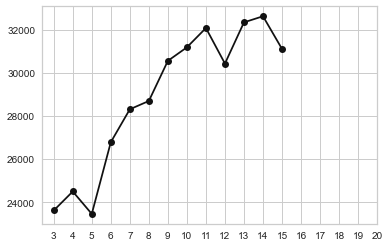

In [142]:

gauss_tune(norm_train, 3,15)

In [291]:
cluster_results = def_train.copy()
gmm = GaussianMixture(5, random_state=29)
kmeans5 = KMeans(5, random_state=2022)
clusters = gmm.fit_predict(norm_train)
cluster_results['Clusters'] = clusters

c:\Users\rpand\anaconda3\envs\nba_app_env\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.



In [292]:

cluster_groups = cluster_results.groupby(clusters).mean()
cluster_groups.to_html('Cluster Data.html')

In [293]:
cluster_groups

,DEF Handoff PPP,DEF Handoff FREQ,DEF Isolation PPP,DEF Isolation FREQ,DEF OffScreen PPP,DEF OffScreen FREQ,DEF Postup PPP,DEF Postup FREQ,DEF PRBallHandler PPP,DEF PRBallHandler FREQ,...,PLUSMINUS Less Than 6Ft,FREQ Less Than 10Ft,PLUSMINUS Less Than 10Ft,PCT_LOOSE_BALLS_RECOVERED_DEF,REB_CONTEST_PCT,AVG_REB_DIST,DIST_MILES_DEF,AVG_SPEED_DEF,DEFLECTIONS Per36,Clusters
0,0.908192,0.085840,0.902840,0.074006,0.930936,0.065692,0.940083,0.049705,0.873737,0.304981,...,0.007026,0.442590,0.007891,0.528885,0.228141,8.321154,0.948333,3.856090,2.207427,0.0
1,0.231441,0.004941,0.958706,0.104176,0.492647,0.007941,0.960294,0.064441,0.592824,0.018912,...,-0.050412,0.516029,-0.040029,0.413059,0.445147,4.976471,0.810588,3.827647,2.008165,1.0
2,0.823816,0.078342,0.819592,0.068224,0.741579,0.055632,0.703447,0.043921,0.893329,0.297921,...,0.010053,0.459934,0.012105,0.528697,0.233658,8.426316,0.775526,3.873816,2.315977,2.0
3,0.049393,0.001250,0.947929,0.075964,0.024714,0.000500,0.883321,0.055536,0.000000,0.000714,...,-0.036107,0.486250,-0.027429,0.384893,0.461786,4.810714,0.652143,3.831786,1.780798,3.0
4,0.939969,0.046154,0.894200,0.114615,0.886200,0.040369,0.956262,0.058446,0.874154,0.124985,...,-0.042323,0.470708,-0.036215,0.495692,0.350846,5.772308,0.856308,3.831846,1.844435,4.0


In [294]:
def_ranks = pd.DataFrame()
for i in cluster_groups.columns:
    def_ranks[i + ' rank'] = cluster_groups[i].rank()

def_ranks.to_html('def_ranks')

In [295]:
player_groups  = all_defence_clust[['PLAYER_NAME', 'Season']].copy()
player_groups['Cluster'] = clusters
player_groups_2021 = player_groups[player_groups['Season']=='2021-22']
player_groups.Cluster.value_counts()

0    156
2     76
4     65
1     34
3     28
Name: Cluster, dtype: int64

In [319]:
player_groups[player_groups['PLAYER_NAME']=='Pascal Siakam']

,PLAYER_NAME,Season,Cluster
1277,Pascal Siakam,2021-22,4


In [297]:
player_groups[player_groups['Cluster']==3]

,PLAYER_NAME,Season,Cluster
1032,Daniel Gafford,2021-22,3
1037,Onyeka Okongwu,2021-22,3
1141,Jalen Smith,2021-22,3
1682,Olivier Sarr,2021-22,3
1693,Derrick Favors,2021-22,3
1699,Robin Lopez,2021-22,3
1706,Alex Len,2021-22,3
1712,Dewayne Dedmon,2021-22,3
1717,Thomas Bryant,2021-22,3
1722,Tristan Thompson,2021-22,3


## Analyze the Large Cluster 0

In [298]:
full_results = all_defence_clust.copy()
full_results['Cluster'] = clusters

In [299]:
full_results.Cluster.value_counts()

0    156
2     76
4     65
1     34
3     28
Name: Cluster, dtype: int64

In [300]:
clust_0 =  cluster_results[cluster_results['Clusters']==0].copy().drop('Clusters', axis='columns')
player_0 = player_groups[player_groups['Cluster']==0].copy()

In [301]:
pc2 = PCA(2)
clust0_pc = pd.DataFrame(pc2.fit_transform(clust_0), columns = ['Component 1', 'Component 2'])


In [302]:


print(f'Variance Explained by these two components is: {pc2.explained_variance_ratio_.sum()}')
np.transpose(pd.DataFrame(pc2.components_, columns= clust_0.columns, index = ['Component 1', 'Component 2'])).sort_values('Component 1')

Variance Explained by these two components is: 0.8627347460298093


,Component 1,Component 2
AVG_REB_DIST,-0.998018,0.005509
DEF PRBallHandler FREQ,-0.020605,0.028112
PCT_LOOSE_BALLS_RECOVERED_DEF,-0.010973,0.034416
PLUSMINUS Less Than 6Ft,-0.007949,-0.000542
PLUSMINUS Less Than 10Ft,-0.005377,-0.000604
FREQ 3 Pointers,-0.004166,-0.002764
DEF Handoff PPP,-0.001791,-0.017722
DEF Handoff FREQ,-0.001122,-0.001950
DEF PRRollman FREQ,-0.000791,-0.000995
DEF Postup FREQ,0.001092,0.000746


In [303]:
np.transpose(pd.DataFrame(pc2.components_, columns= clust_0.columns, index = ['Component 1', 'Component 2'])).sort_values('Component 2')

,Component 1,Component 2
DIST_MILES_DEF,0.014580,-0.037984
DEF OffScreen PPP,0.005573,-0.036072
DEF Isolation PPP,0.014463,-0.025062
DEF Spotup PPP,0.010614,-0.022065
DEF Handoff PPP,-0.001791,-0.017722
DEF PRBallHandler PPP,0.001198,-0.013271
DEF Spotup FREQ,0.008465,-0.011560
PLUSMINUS 3 Pointers,0.002952,-0.005713
DEF Isolation FREQ,0.004779,-0.005006
FREQ 3 Pointers,-0.004166,-0.002764


In [304]:
fig = go.Figure()
fig.add_scatter(x = clust0_pc['Component 1'], y = clust0_pc['Component 2'], name = 'Cluster 0', mode = 'markers', marker = dict(color = 'black' ), hoverinfo = 'skip', customdata=player_0.PLAYER_NAME, hovertemplate = 'Player: %{customdata}<br><extra></extra>' )


In [309]:
def sub_cluster(df):
    df['SubGroup'] = [0]*len(df)
    df['SubGroup'].loc[(df['Component 2']>0.5)] = 0

    df['SubGroup'].loc[(df['Component 2']<0.5)] = 1






    

In [310]:
sub_cluster(clust0_pc)

C:\Users\rpand\AppData\Local\Temp\ipykernel_38572\2976462210.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\rpand\AppData\Local\Temp\ipykernel_38572\2976462210.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [311]:
sub_clust0 = clust0_pc.SubGroup.values

In [312]:
player_0['Subgroup'] = sub_clust0
clust_0['Subgroup'] = sub_clust0

,PLAYER_NAME,Season,Cluster,Subgroup
1068,Justin Holiday,2021-22,0,1
1070,Aaron Holiday,2021-22,0,3
1073,Tyrese Haliburton,2021-22,0,1
1076,Gabe Vincent,2021-22,0,1
1078,James Harden,2021-22,0,0
...,...,...,...,...
1385,Trae Young,2021-22,0,1
1386,Donovan Mitchell,2021-22,0,1
1387,Jordan Poole,2021-22,0,3
1388,Jordan Clarkson,2021-22,0,2


## Analyze Cluster 4

In [279]:
def pca_clust(data, players):
    pc2 = PCA(2)
    cluster_pca = pd.DataFrame(pc2.fit_transform(data), columns = ['Component 1', 'Component 2'])
    
    print(f'Variance Explained by these two components is: {pc2.explained_variance_ratio_.sum()}')
    comps = np.transpose(pd.DataFrame(pc2.components_, columns= data.columns, index = ['Component 1', 'Component 2']))
    fig = go.Figure()
    fig.add_scatter(x = cluster_pca['Component 1'], y = cluster_pca['Component 2'], name = 'Cluster 0', mode = 'markers', marker = dict(color = 'black' ), hoverinfo = 'skip', customdata=players.PLAYER_NAME, hovertemplate = 'Player: %{customdata}<br><extra></extra>' )
    fig.show()
    return(comps)

In [316]:
clust_4 =  cluster_results[cluster_results['Clusters']==4].copy().drop('Clusters', axis='columns')
player_4 = player_groups[player_groups['Cluster']==4].copy()

In [317]:
comps = pca_clust(clust_4, player_4)

Variance Explained by these two components is: 0.6876697074732836


In [320]:
comps.sort_values('Component 2')

,Component 1,Component 2
AVG_REB_DIST,0.980411,-0.121028
DEF OffScreen PPP,0.096085,-0.060506
DEF Handoff PPP,-0.032713,-0.055563
AVG_SPEED_DEF,0.011503,-0.019693
DEF Isolation FREQ,0.003006,-0.010233
PLUSMINUS Less Than 6Ft,0.007732,-0.004811
PLUSMINUS Less Than 10Ft,0.006617,-0.002486
DEF Handoff FREQ,0.009758,-0.002395
DEF OffScreen FREQ,0.012666,-0.001444
DEF Postup FREQ,0.001546,-0.000542


## Offence Clustering

In [5]:
all_offence_clust = pd.read_csv('all_offence.csv')

all_offence_clust = all_offence_clust[(all_offence_clust['GP']>20)& (all_offence_clust['MIN']>15)]

In [15]:
all_offence_clust[all_offence_clust['PLAYER_NAME']=='Pascal Siakam']

,PLAYER_NAME,Season,Cut PPP,Cut FREQ,GP,Handoff PPP,Handoff FREQ,Isolation PPP,Isolation FREQ,Misc PPP,...,FG3A,USG_PCT,POTENTIAL_AST FREQ,Restricted Area FREQ,In The Paint (Non-RA) FREQ,Mid-Range FREQ,3P FREQ,Drives FREQ,PULL_UP FREQ,CATCH_SHOOT FREQ
69,Pascal Siakam,2021-22,1.389,0.046,68,1.184,0.031,0.902,0.236,0.756,...,3.2,0.257,0.467249,0.335616,0.445205,0.219178,0.179775,0.624454,0.280899,0.179775


In [788]:
off_train = all_offence_clust.drop(['PLAYER_NAME', 'Season', 'GP', 'MIN', 'Misc PPP', 'Misc FREQ', "Total Poss", 'POTENTIAL_AST','PULL_UP_FG3_PCT', 'CATCH_SHOOT_FG_PCT' ], axis='columns')

In [789]:
(off_train['Mid-Range FREQ'].values>1).sum()

0

In [790]:
norm_off_train = pd.DataFrame(StandardScaler().fit_transform(off_train),columns = off_train.columns)

c:\Users\rpand\anaconda3\envs\nba_app_env\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.

c:\Users\rpand\anaconda3\envs\nba_app_env\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.

c:\Users\rpand\anaconda3\envs\nba_app_env\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.

c:\Users\rpand\anaconda3\envs\nba_app_env\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning:

KMeans is known to have

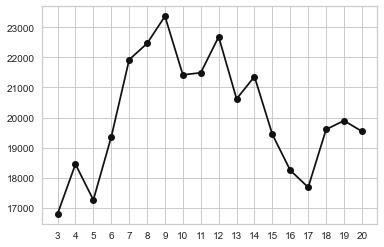

In [791]:
gauss_tune(norm_off_train, 3,20)

In [806]:
off_cluster_results = off_train.copy()
gmm = GaussianMixture(17, random_state=29)
off_clusters = gmm.fit_predict(norm_off_train)
off_cluster_results['Clusters'] = off_clusters

c:\Users\rpand\anaconda3\envs\nba_app_env\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.



In [807]:

off_cluster_groups = off_cluster_results.groupby(off_clusters).mean()
off_cluster_groups.to_html('Offence Cluster Data.html')
off_player_groups  = all_offence_clust[['PLAYER_NAME', 'Season']].copy()
off_player_groups['Cluster'] = off_clusters
off_player_groups.Cluster.value_counts()

3     32
9     30
11    27
0     26
14    24
10    22
6     21
1     19
2     18
15    18
8     18
7     16
12    15
4     15
13    14
16    13
5      7
Name: Cluster, dtype: int64

In [839]:
off_cluster_groups

,Cut PPP,Cut FREQ,Handoff PPP,Handoff FREQ,Isolation PPP,Isolation FREQ,OffScreen PPP,OffScreen FREQ,Postup PPP,Postup FREQ,...,USG_PCT,POTENTIAL_AST FREQ,Restricted Area FREQ,In The Paint (Non-RA) FREQ,Mid-Range FREQ,3P FREQ,Drives FREQ,PULL_UP FREQ,CATCH_SHOOT FREQ,Clusters
0,1.183577,0.031462,0.910769,0.099423,0.861192,0.056154,0.969115,0.083154,0.026923,0.000423,...,0.210731,0.374927,0.407665,0.272326,0.320009,0.519376,0.403745,0.363344,0.348195,0.0
1,1.314316,0.131368,0.072421,0.002421,0.647316,0.033684,0.283632,0.007105,0.911947,0.146316,...,0.196895,0.326910,0.490377,0.331539,0.178083,0.240540,0.201730,0.106662,0.310938,1.0
2,1.208222,0.153667,0.206333,0.008389,0.233722,0.010944,0.000000,0.000000,0.174778,0.008722,...,0.145889,0.314781,0.761026,0.177500,0.061474,0.359437,0.251103,0.055778,0.350507,2.0
3,1.327937,0.058031,0.849906,0.055531,0.876781,0.049875,0.881219,0.030469,0.272062,0.010281,...,0.183812,0.406264,0.542517,0.317844,0.139640,0.420479,0.480686,0.195139,0.335122,3.0
4,1.315067,0.277933,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.570733,0.054800,...,0.141333,0.306102,0.741245,0.224675,0.034080,0.015390,0.055569,0.021714,0.048119,4.0
5,0.906714,0.044000,0.383000,0.024571,0.514286,0.066429,0.000000,0.000000,0.000000,0.000000,...,0.158714,1.251645,0.485207,0.302344,0.212449,0.280267,1.127054,0.312704,0.183101,5.0
6,1.252000,0.063905,0.837857,0.063524,0.034381,0.001286,0.998571,0.059667,0.034905,0.001095,...,0.151095,0.327365,0.487996,0.261587,0.250417,0.602519,0.278453,0.177041,0.547792,6.0
7,1.362000,0.048125,0.925063,0.045000,0.787438,0.082000,0.801500,0.050500,0.983125,0.094625,...,0.209563,0.274463,0.368518,0.306275,0.325207,0.431991,0.334799,0.282498,0.383558,7.0
8,0.717889,0.026667,0.977111,0.132333,0.179056,0.008500,0.965222,0.147722,0.049389,0.002333,...,0.178833,0.305490,0.457135,0.263057,0.279808,0.717009,0.247812,0.255062,0.563775,8.0
9,1.088167,0.019033,0.916267,0.059567,0.918133,0.141600,0.936067,0.035900,0.346667,0.013500,...,0.276067,0.537241,0.379052,0.349169,0.271779,0.393658,0.643719,0.451757,0.172106,9.0


In [840]:
off_player_groups[off_player_groups['PLAYER_NAME']=='OG Anunoby']

,PLAYER_NAME,Season,Cluster
140,OG Anunoby,2021-22,7


In [842]:
off_player_groups[off_player_groups['Cluster']==9]

,PLAYER_NAME,Season,Cluster
76,Russell Westbrook,2021-22,9
101,Bradley Beal,2021-22,9
109,Jrue Holiday,2021-22,9
122,Tyler Herro,2021-22,9
149,Anthony Edwards,2021-22,9
151,Ja Morant,2021-22,9
177,Dejounte Murray,2021-22,9
187,D'Angelo Russell,2021-22,9
208,Reggie Jackson,2021-22,9
228,Caris LeVert,2021-22,9


In [ ]:
def_ranks = pd.DataFrame()
for i in cluster_groups.columns:
    def_ranks[i + ' rank'] = cluster_groups[i].rank()

def_ranks.to_html('def_ranks')

In [845]:
comps = pca_clust(off_cluster_results[off_cluster_results['Clusters']==13].drop('Clusters', axis=1), off_player_groups[off_player_groups['Cluster']==13])

Variance Explained by these two components is: 0.9357066588169768


In [1]:
comps.sort_values('Component 2')

NameError: name 'comps' is not defined

## Overall Player List

In [16]:
players = pd.merge(all_defence_clust, all_offence_clust, on =['PLAYER_NAME'], how = 'inner')

In [24]:
players[['PLAYER_NAME']].sort_values('PLAYER_NAME', ascending = True).to_csv('Player Data.csv',index=False)

In [19]:
players[players['PLAYER_NAME']=='Pascal Siakam']

,PLAYER_NAME,Season_x,DEF Handoff PPP,DEF Handoff FREQ,GP_x,DEF Isolation PPP,DEF Isolation FREQ,DEF OffScreen PPP,DEF OffScreen FREQ,DEF Postup PPP,...,FG3A,USG_PCT,POTENTIAL_AST FREQ,Restricted Area FREQ,In The Paint (Non-RA) FREQ,Mid-Range FREQ,3P FREQ,Drives FREQ,PULL_UP FREQ,CATCH_SHOOT FREQ
190,Pascal Siakam,2021-22,1.083,0.04,69,0.645,0.085,1.435,0.052,0.871,...,3.2,0.257,0.467249,0.335616,0.445205,0.219178,0.179775,0.624454,0.280899,0.179775
